In [1]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68616192/68606236 [==============================] - 7s 0us/step


In [3]:
batch_size = 32
img_height = 160
img_width = 160

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 800 files for training.


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [8]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1)
])

In [9]:
base_learning_rate = 0.0001
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
initial_epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epochs
)

Epoch 1/10
50/50 [==============================] - 9s 92ms/step - loss: 0.7531 - accuracy: 0.5225 - val_loss: 0.6008 - val_accuracy: 0.6388
Epoch 2/10
50/50 [==============================] - 4s 79ms/step - loss: 0.5224 - accuracy: 0.7188 - val_loss: 0.4394 - val_accuracy: 0.7887
Epoch 3/10
50/50 [==============================] - 4s 78ms/step - loss: 0.3881 - accuracy: 0.8250 - val_loss: 0.3420 - val_accuracy: 0.8562
Epoch 4/10
50/50 [==============================] - 4s 78ms/step - loss: 0.3059 - accuracy: 0.8788 - val_loss: 0.2819 - val_accuracy: 0.8975
Epoch 5/10
50/50 [==============================] - 4s 77ms/step - loss: 0.2538 - accuracy: 0.9000 - val_loss: 0.2414 - val_accuracy: 0.9162
Epoch 6/10
50/50 [==============================] - 4s 77ms/step - loss: 0.2179 - accuracy: 0.9169 - val_loss: 0.2132 - val_accuracy: 0.9237
Epoch 7/10
50/50 [==============================] - 4s 78ms/step - loss: 0.1921 - accuracy: 0.9312 - val_loss: 0.1924 - val_accuracy: 0.9362
Epoch 8/10
50

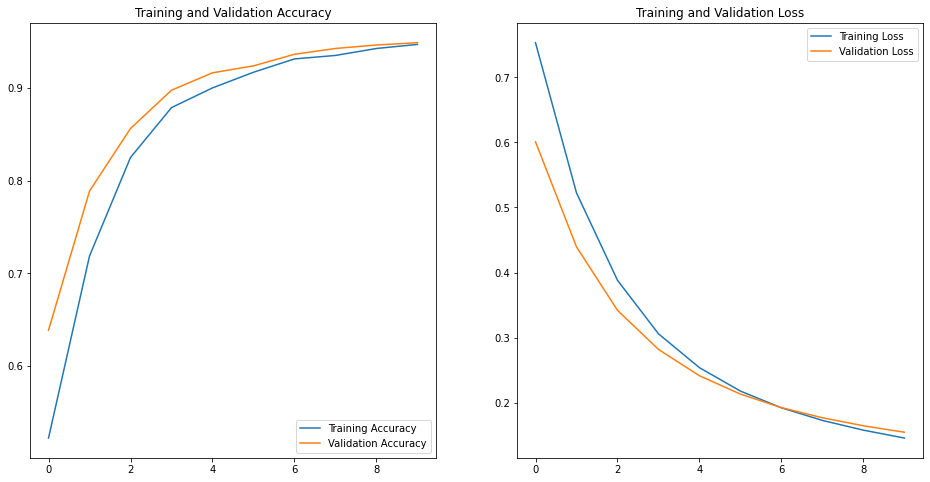

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
base_model.trainable = True

# 해당 층 이후부터 미세 조정
fine_tune_at = 100

# `fine_tune_at` 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [14]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
50/50 [==============================] - 8s 111ms/step - loss: 0.3376 - accuracy: 0.8806 - val_loss: 0.1114 - val_accuracy: 0.9613
Epoch 11/20
50/50 [==============================] - 5s 100ms/step - loss: 0.1817 - accuracy: 0.9475 - val_loss: 0.0976 - val_accuracy: 0.9663
Epoch 12/20
50/50 [==============================] - 5s 100ms/step - loss: 0.1224 - accuracy: 0.9700 - val_loss: 0.0887 - val_accuracy: 0.9688
Epoch 13/20
50/50 [==============================] - 5s 100ms/step - loss: 0.0893 - accuracy: 0.9800 - val_loss: 0.0833 - val_accuracy: 0.9688
Epoch 14/20
50/50 [==============================] - 5s 100ms/step - loss: 0.0674 - accuracy: 0.9894 - val_loss: 0.0808 - val_accuracy: 0.9700
Epoch 15/20
50/50 [==============================] - 5s 100ms/step - loss: 0.0518 - accuracy: 0.9956 - val_loss: 0.0787 - val_accuracy: 0.9688
Epoch 16/20
50/50 [==============================] - 5s 101ms/step - loss: 0.0409 - accuracy: 0.9987 - val_loss: 0.0772 - val_accuracy: 0.9700

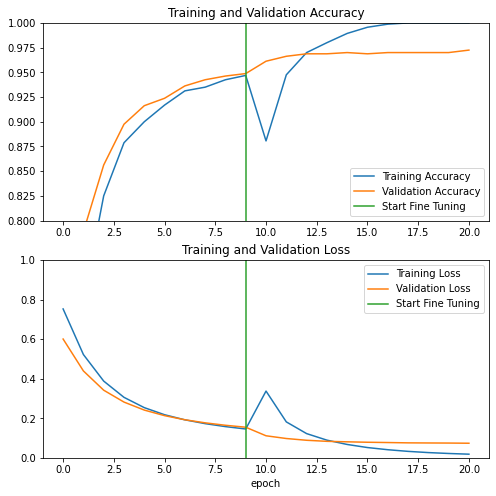

In [15]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()